In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from scipy.stats import kstest, mannwhitneyu
from scipy.stats import ks_2samp
import itertools
# import shap

from tqdm import tqdm

import matplotlib.pyplot as plt
import pingouin as pg
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

met_file_path = "C:/Users/shrra/Downloads/merged_n586_Alasdair_May21_concatenated_renamed.csv"
met1_df = pd.read_csv(met_file_path)
# print(met1_df.columns)


In [3]:
met1_df_T  = met1_df.T

In [4]:


met1_df_T.reset_index(inplace=True)

# Set the first row as the header
met1_df_T.columns = met1_df_T.iloc[0]
met1_df_T = met1_df_T[1:]

# Reset the index again (if you want to have a clean numeric index)
met1_df_T.reset_index(drop=True, inplace=True)

# Rename the newly created index column (if needed)
met1_df_T.rename(columns={met1_df_T.columns[0]: 'ID'}, inplace=True)


# print(met1_df_T.columns)


In [5]:
met1_df_T['ID'] = met1_df_T['ID'].str.replace('-S.*', '', regex=True)
# print(len(met1_df_T))
# print(met1_df_T.columns)


In [6]:
mas_file_path = "C:/Users/shrra/Downloads/MASH_biomarkers_clinicaldata_notimputed_May30_HH.csv"
mash_df = pd.read_csv(mas_file_path)
mash_df['MASH'] = mash_df['MASH'].map({'MASH': 1, 'non-MASH': 0})
# print(mash_df.columns)


In [7]:
id_df = mash_df[['ID', 'MASH']]


In [8]:
id_df['ID'] = id_df['ID'].str.replace('5-00', '')
id_df['ID'] = id_df['ID'].str.replace('5-0', '')

C:\Users\shrra\AppData\Local\Temp\ipykernel_5100\3199667862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_df['ID'] = id_df['ID'].str.replace('5-00', '')
C:\Users\shrra\AppData\Local\Temp\ipykernel_5100\3199667862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_df['ID'] = id_df['ID'].str.replace('5-0', '')


In [9]:
df1 = id_df[['ID']]
df2 = met1_df_T[['ID']]


set1 = set(df1['ID'])
set2 = set(df2['ID'])

# Find values in df1['ID'] that are not in df2['ID']
missing_in_df2 = set1 - set2

# Find values in df2['ID'] that are not in df1['ID']
missing_in_df1 = set2 - set1

# # Display the missing values
# print("\nID Values in mash file that are not in metab file")
# print(missing_in_df2)
# print(len(missing_in_df2))
# print("\nID Values in metab file that are not in mash file")
# print(missing_in_df1)
# print(len(missing_in_df1))

In [10]:
Updated_meta_df = pd.merge(id_df, met1_df_T, on=['ID'], how='inner')

In [11]:
KSTest_df = Updated_meta_df


excluded_cols = ["ID"]
KSTest_df= KSTest_df.drop(columns=excluded_cols)

In [12]:
count_zeros = (KSTest_df == 0).any(axis=1).sum()

print(f"Number of records with at least one 0 value: {count_zeros}")

Number of records with at least one 0 value: 586


In [13]:
#fill 0 

columns_to_fill = KSTest_df.columns[KSTest_df.columns != 'MASH']

# Replace 0s with NaNs in the selected columns
KSTest_df[columns_to_fill] = KSTest_df[columns_to_fill].replace(0, np.nan)

C:\Users\shrra\AppData\Local\Temp\ipykernel_5100\1758939555.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  KSTest_df[columns_to_fill] = KSTest_df[columns_to_fill].replace(0, np.nan)


In [14]:
nan_counts = KSTest_df.isna().sum()

print("Number of NaN values in each column:")
print(nan_counts)
non_nan_columns_count = KSTest_df.notna().all().sum()

print(f"Number of columns without any NaN values: {non_nan_columns_count}")

Number of NaN values in each column:
MASH                  0
85.9631_153.8       114
86.0601_71.8          1
86.0965_42.45         0
86.9087_49.05         0
                   ... 
1178.78305_64.8      29
1179.2791_65.5      159
1179.77765_65.45     96
1212.76635_65.5     137
1247.76475_65.65    183
Length: 3759, dtype: int64
Number of columns without any NaN values: 441


Data prep

In [15]:
cat_11= ['ID','MASH','431.3519_25.7', '384.38365_24.45', '423.3297_25.7', '640.6039_52.4',
    '131.1066_25.95', '745.55655_30.45', '137.0791_58', '153.0404_59.75',
    '806.49335_53.65', '776.5762_46.8', '119.06855_53.2']
clin_10=['AST (U/L)', 'ALT (U/L)','GGT (U/L)','Platelet count','HOMA-IR','Insulin (uU/mL)','BMI z-score','TG:HDL ratio','Alk phos (U/L)','HDL-c (mg/dL)']

In [16]:

metab_10df= Updated_meta_df[cat_11]
clin_15_df = mash_df[clin_10]
final_df = pd.DataFrame()
final_df
final_10df = pd.concat([metab_10df,clin_15_df], axis=1)

In [17]:
columns_to_convert = ['431.3519_25.7', '384.38365_24.45', '423.3297_25.7', '640.6039_52.4',
    '131.1066_25.95', '745.55655_30.45', '137.0791_58', '153.0404_59.75',
    '806.49335_53.65', '776.5762_46.8', '119.06855_53.2']  # replace with your column names

# Convert specified columns to float
final_10df[columns_to_convert] = final_10df[columns_to_convert].astype(float)

columns_to_fill = final_10df.columns[final_10df.columns != 'MASH']

# Replace 0s with NaNs in the selected columns
final_10df[columns_to_fill] = final_10df[columns_to_fill].replace(0, np.nan)

# Print the data types of the columns
print(final_10df.dtypes)

ID                  object
MASH                 int64
431.3519_25.7      float64
384.38365_24.45    float64
423.3297_25.7      float64
640.6039_52.4      float64
131.1066_25.95     float64
745.55655_30.45    float64
137.0791_58        float64
153.0404_59.75     float64
806.49335_53.65    float64
776.5762_46.8      float64
119.06855_53.2     float64
AST (U/L)          float64
ALT (U/L)          float64
GGT (U/L)          float64
Platelet count     float64
HOMA-IR            float64
Insulin (uU/mL)    float64
BMI z-score        float64
TG:HDL ratio       float64
Alk phos (U/L)     float64
HDL-c (mg/dL)      float64
dtype: object


In [19]:

final_10df = final_10df.rename(columns={'BMI z-score': 'BMIzscore'})
final_10df = final_10df.rename(columns={'AST (U/L)': 'AST'})
final_10df = final_10df.rename(columns={'ALT (U/L)': 'ALT'})
final_10df = final_10df.rename(columns={'GGT (U/L)': 'GGT'})
final_10df = final_10df.rename(columns={'Platelet count': 'Plateletcount'})
final_10df = final_10df.rename(columns={'Insulin (uU/mL)': 'Insulin'})
final_10df = final_10df.rename(columns={'Alk phos (U/L)': 'Alkphos'})

final_10df = final_10df.rename(columns={'HOMA-IR': 'HOMAIR'})

final_10df = final_10df.rename(columns={'HDL-c (mg/dL)': 'HDLc_mgdL'})
final_10df = final_10df.rename(columns={'TG:HDL ratio': 'TGHDLratio'})
# final_10df.columns = final_10df.columns.str.lower()

ML model Catboost

0:	learn: 0.6887150	test: 0.6900388	best: 0.6900388 (0)	total: 4.73ms	remaining: 468ms
1:	learn: 0.6850527	test: 0.6862162	best: 0.6862162 (1)	total: 7.01ms	remaining: 343ms
2:	learn: 0.6815004	test: 0.6826344	best: 0.6826344 (2)	total: 9.12ms	remaining: 295ms
3:	learn: 0.6769455	test: 0.6791099	best: 0.6791099 (3)	total: 11.1ms	remaining: 265ms
4:	learn: 0.6727223	test: 0.6759990	best: 0.6759990 (4)	total: 13.6ms	remaining: 258ms
5:	learn: 0.6686404	test: 0.6735534	best: 0.6735534 (5)	total: 15.7ms	remaining: 246ms
6:	learn: 0.6651195	test: 0.6700480	best: 0.6700480 (6)	total: 17.6ms	remaining: 234ms
7:	learn: 0.6615468	test: 0.6671441	best: 0.6671441 (7)	total: 20.3ms	remaining: 234ms
8:	learn: 0.6585451	test: 0.6638822	best: 0.6638822 (8)	total: 23ms	remaining: 233ms
9:	learn: 0.6558283	test: 0.6614596	best: 0.6614596 (9)	total: 25ms	remaining: 225ms
10:	learn: 0.6530080	test: 0.6603257	best: 0.6603257 (10)	total: 27.5ms	remaining: 222ms
11:	learn: 0.6502231	test: 0.6580968	best: 0.

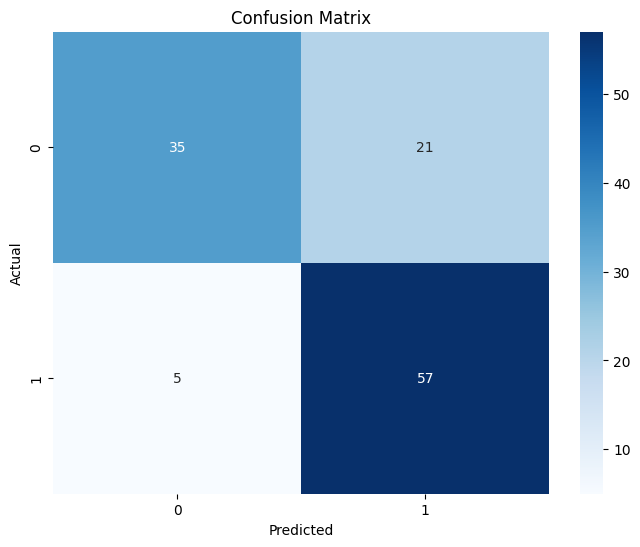

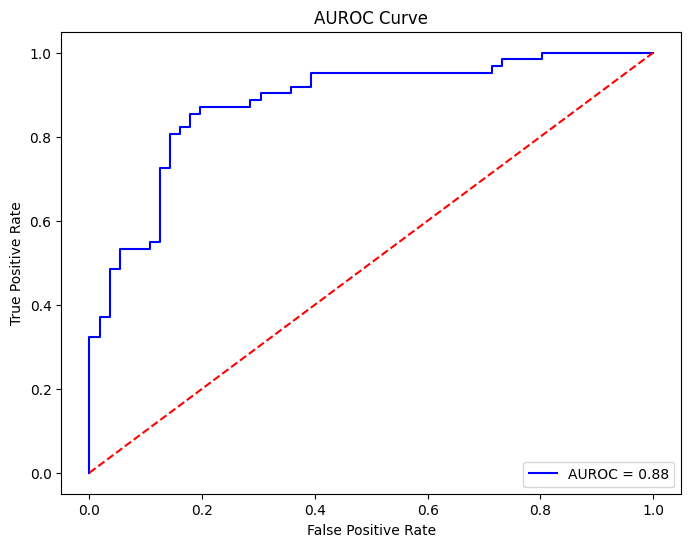

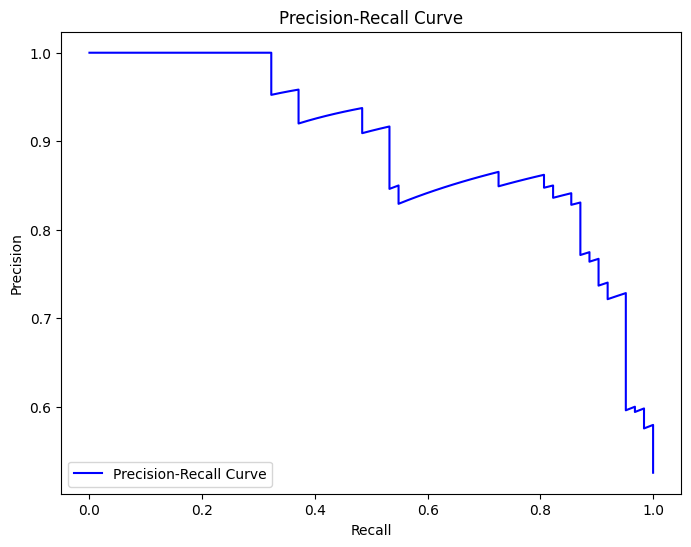

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns


data = final_10df
data = data.drop(columns='ID')
target = 'MASH'
features = [col for col in data.columns if col != target]

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# CatBoostClassifier
model = CatBoostClassifier(iterations=100, 
                           learning_rate=0.01, 
                           depth=6)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# accuracy and classification report
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# AUROC 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve')
plt.legend(loc='lower right')
plt.show()

# precision curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


LightGBM

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 278, number of negative: 190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2814
[LightGBM] [Info] Number of data points in the train set: 468, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594017 -> initscore=0.380597
[LightGBM] [Info] Start training from score 0.380597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

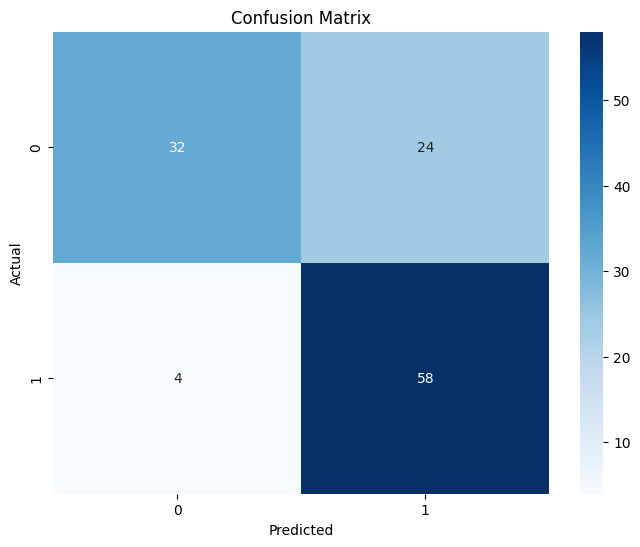

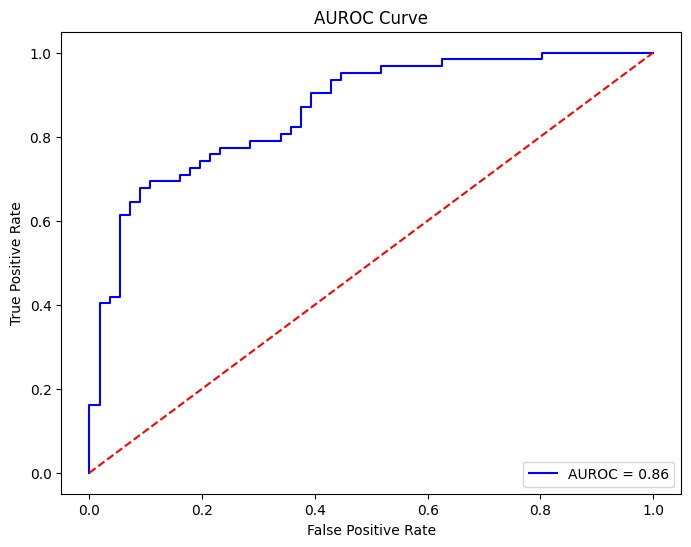

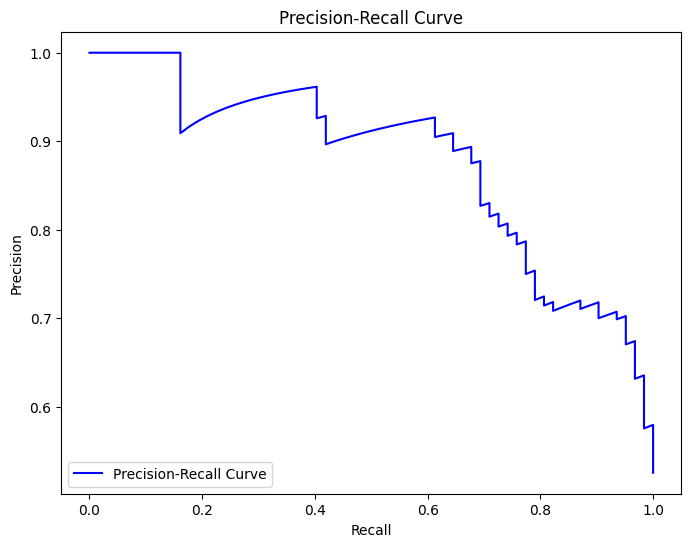

In [34]:

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

data = final_10df
data = data.drop(columns='ID')
target = 'MASH'
features = [col for col in data.columns if col != target]

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# LightGBM Classifier
model = lgb.LGBMClassifier(n_estimators=100, 
                           learning_rate=0.01, 
                           max_depth=6, 
                           objective='binary')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# accuracy and classification report
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve')
plt.legend(loc='lower right')
plt.show()

# precision curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


SVM

Fill missing values with median

In [20]:

final_10df_median_filled = final_10df

# Columns to exclude
exclude_columns = ['ID', 'MASH']

# Get the columns that need to be filled with the median
columns_to_fill = final_10df_median_filled.columns.difference(exclude_columns)

# Fill NaN values with the median of each column, excluding the specified columns
final_10df_median_filled[columns_to_fill] = final_10df_median_filled[columns_to_fill].apply(lambda x: x.fillna(x.median()), axis=0)

# Check if NaN values are filled
print(final_10df_median_filled.isnull().sum())

ID                 0
MASH               0
431.3519_25.7      0
384.38365_24.45    0
423.3297_25.7      0
640.6039_52.4      0
131.1066_25.95     0
745.55655_30.45    0
137.0791_58        0
153.0404_59.75     0
806.49335_53.65    0
776.5762_46.8      0
119.06855_53.2     0
AST                0
ALT                0
GGT                0
Plateletcount      0
HOMAIR             0
Insulin            0
BMIzscore          0
TGHDLratio         0
Alkphos            0
HDLc_mgdL          0
dtype: int64


Accuracy: 0.7203
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.57      0.66        56
           1       0.69      0.85      0.76        62

    accuracy                           0.72       118
   macro avg       0.73      0.71      0.71       118
weighted avg       0.73      0.72      0.71       118



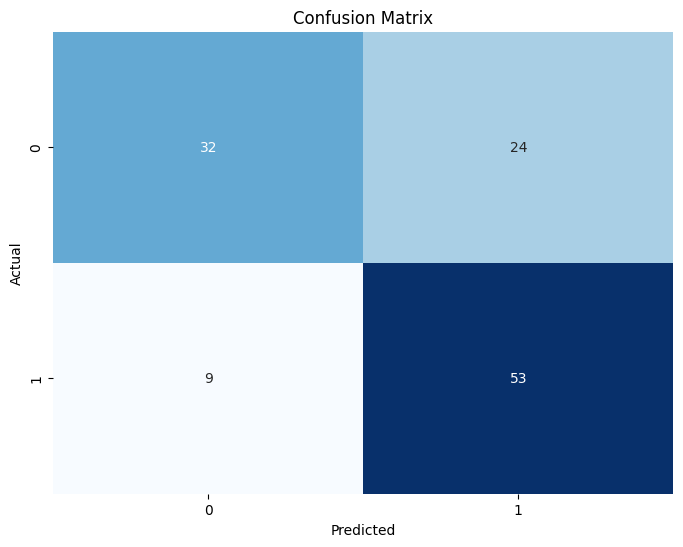

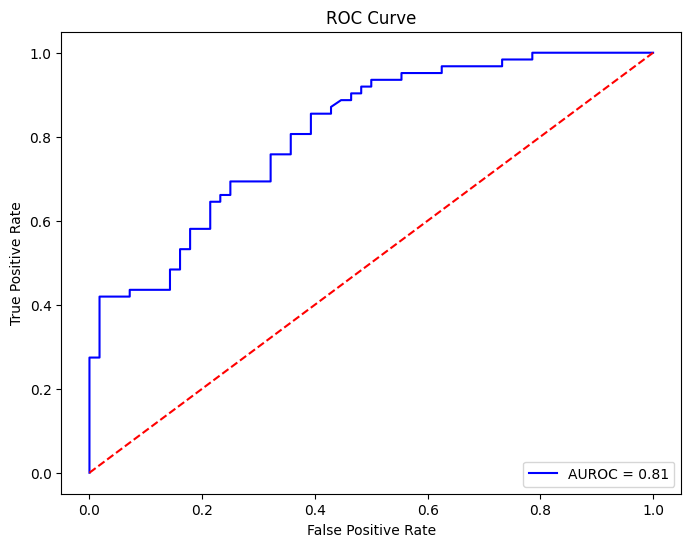

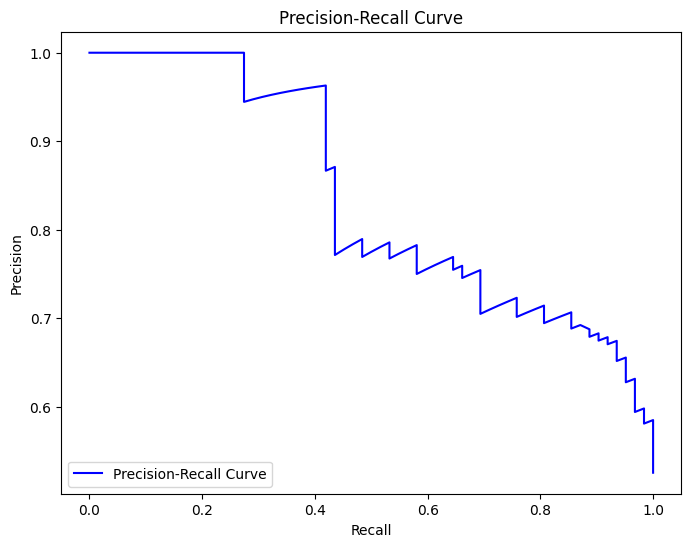

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load your dataset
# Assuming 'final_10df_median_filled' is your DataFrame after filling NaN values
data = final_10df_median_filled
data = data.drop(columns='ID')

# Define the target and features
target = 'MASH'
features = [col for col in data.columns if col != target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train SVM model with RBF kernel
model = SVC(kernel='rbf', probability=True, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy and classification report
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auroc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
